In [6]:
# Celda de imports
try:
    import shap
    SHAP_OK = True
except Exception as e:        # captura cualquier ImportError
    SHAP_OK = False
    print(f"· Aviso: SHAP desactivado ({e})")

# Celda de summary plot
if SHAP_OK:
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(test_df[FEATURES].head(5_000))
    shap.summary_plot(shap_vals, test_df[FEATURES].head(5_000), show=False)
    plt.title("SHAP summary (LightGBM)")
    plt.show()


· Aviso: SHAP desactivado (Numba needs NumPy 1.26 or less)


In [12]:
# %% ——————————————————————————
# Configuración global + lectura
# --------------------------------

import sys, pathlib, warnings, json, joblib, gc, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, PrecisionRecallDisplay,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import lightgbm as lgb

# —— SHAP opcional ——
try:
    import shap
    SHAP_OK = True
except Exception as e:
    SHAP_OK = False
    print(f"· Aviso: SHAP desactivado ({e})")

# —— rutas ——
ROOT = pathlib.Path().resolve()
for p in [ROOT] + list(ROOT.parents):
    if (p / "memebot3").is_dir():
        REPO = p
        break
else:
    raise RuntimeError("✗ No encuentro la carpeta ‘memebot3’")

PARQUET = REPO / "memebot3" / "data" / "features" / "features_202507.parquet"
assert PARQUET.exists(), PARQUET

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme()

start = time.time()
df = pd.read_parquet(PARQUET)
print("Shape:", df.shape, f"— cargado en {time.time()-start:.1f}s")

mem_mb = df.memory_usage(deep=True).sum() / 1e6
print(f"Memoria dataframe ≈ {mem_mb:.1f} MB")


· Aviso: SHAP desactivado (Numba needs NumPy 1.26 or less)
Shape: (898079, 22) — cargado en 0.5s
Memoria dataframe ≈ 193.0 MB


In [13]:
# %%
df.info()

null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(null_pct.head(15).to_frame("null_%"))

# Resumen estadístico ampliado
display(df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99]).T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898079 entries, 0 to 898078
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   address              898079 non-null  object        
 1   timestamp            898079 non-null  datetime64[us]
 2   discovered_via       898079 non-null  object        
 3   age_minutes          898079 non-null  float32       
 4   liquidity_usd        898079 non-null  float32       
 5   volume_24h_usd       898079 non-null  float32       
 6   txns_last_5m         898079 non-null  int32         
 7   holders              898079 non-null  int32         
 8   rug_score            898079 non-null  int32         
 9   cluster_bad          898079 non-null  int8          
 10  mint_auth_renounced  898079 non-null  int8          
 11  price_pct_1m         898079 non-null  float32       
 12  price_pct_5m         898079 non-null  float32       
 13  volume_pct_5m 

,null_%
address,0.0
timestamp,0.0
discovered_via,0.0
age_minutes,0.0
liquidity_usd,0.0
volume_24h_usd,0.0
txns_last_5m,0.0
holders,0.0
rug_score,0.0
cluster_bad,0.0


,count,mean,min,1%,10%,25%,50%,75%,90%,99%,max,std
timestamp,898079,2025-07-15 18:04:22.068628,2025-07-12 16:51:01.038290,2025-07-12 18:02:26.166180,2025-07-13 04:37:19.816450,2025-07-13 23:01:37.372295,2025-07-15 12:34:54.899406,2025-07-17 09:22:55.258425,2025-07-18 18:58:40.572000,2025-07-19 16:38:46.433317,2025-07-19 19:03:15.928552,NaN
age_minutes,898079.0,5074.576172,0.866006,110.207349,811.24032,2011.783325,4485.374512,7389.523193,9474.861328,18905.42957,24466.746094,3848.608398
liquidity_usd,898079.0,14102.96582,0.0,0.0,0.0,3421.72998,7216.600098,10170.089844,25792.459766,131852.546875,351790.40625,31230.798828
volume_24h_usd,898079.0,110088.578125,0.0,0.25,7.83,87.099998,1506.23999,25862.740234,240062.375,2490151.61,6409243.5,445085.375
txns_last_5m,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
holders,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rug_score,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cluster_bad,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mint_auth_renounced,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
price_pct_1m,898079.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# %% ——— Duplicados seguros ————————————————————————————
# 1) Mostrar columnas disponibles (útil la primera vez)
print("Columnas en el dataframe:", df.columns.tolist())

# 2) Definir posibles nombres “clave”
candidatas_pair = ["pair", "token_address", "symbol"]
col_pair = next((c for c in candidatas_pair if c in df.columns), None)

# 3) Construir la lista final de columnas clave
key_cols = ["timestamp"] + ([col_pair] if col_pair else [])

if len(key_cols) == 1:          # sólo timestamp
    print("· Aviso: no se encontró columna 'pair'; se usará sólo 'timestamp' para duplicados.")

# 4) Calcular duplicados
dup = df.duplicated(subset=key_cols).sum()
print(f"Duplicados usando {key_cols}: {dup}")


Columnas en el dataframe: ['address', 'timestamp', 'discovered_via', 'age_minutes', 'liquidity_usd', 'volume_24h_usd', 'txns_last_5m', 'holders', 'rug_score', 'cluster_bad', 'mint_auth_renounced', 'price_pct_1m', 'price_pct_5m', 'volume_pct_5m', 'social_ok', 'twitter_followers', 'discord_members', 'score_total', 'trend', 'is_incomplete', 'label', 'ts']
· Aviso: no se encontró columna 'pair'; se usará sólo 'timestamp' para duplicados.
Duplicados usando ['timestamp']: 1


label
0    881189
1     16890
Name: count, dtype: int64 
Proporción positiva: 0.018806808755131788


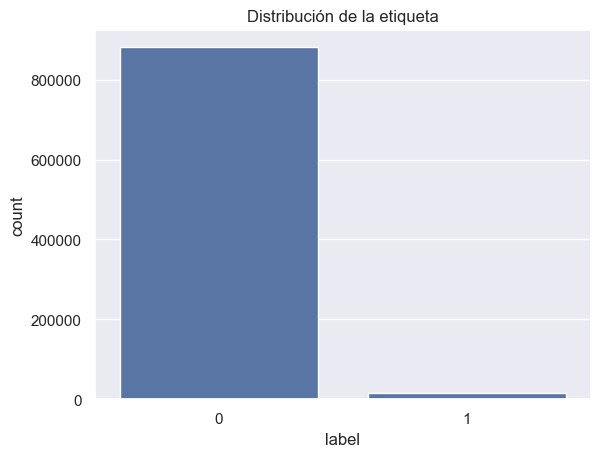

In [16]:
# %%
label_counts = df["label"].value_counts(dropna=False)
print(label_counts, "\nProporción positiva:", label_counts.get(1,0) / label_counts.sum())

sns.countplot(x="label", data=df)
plt.title("Distribución de la etiqueta"); plt.show()


In [17]:
# %%
num_cols = df.select_dtypes(include=[np.number]).columns.drop("label")
pbiserial = {
    col: stats.pointbiserialr(df["label"], df[col].fillna(df[col].median()))[0]
    for col in num_cols
}
corr_ser = pd.Series(pbiserial).sort_values(key=np.abs, ascending=False)
display(corr_ser.head(25).to_frame("pbiserial"))


d:\Dev\Python\memebot3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
d:\Dev\Python\memebot3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
d:\Dev\Python\memebot3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
d:\Dev\Python\memebot3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
d:\Dev\Python\memebot3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x

,pbiserial
score_total,0.178370
age_minutes,-0.176128
volume_24h_usd,0.074208
liquidity_usd,0.070025
is_incomplete,-0.068020
txns_last_5m,NaN
holders,NaN
rug_score,NaN
cluster_bad,NaN
mint_auth_renounced,NaN


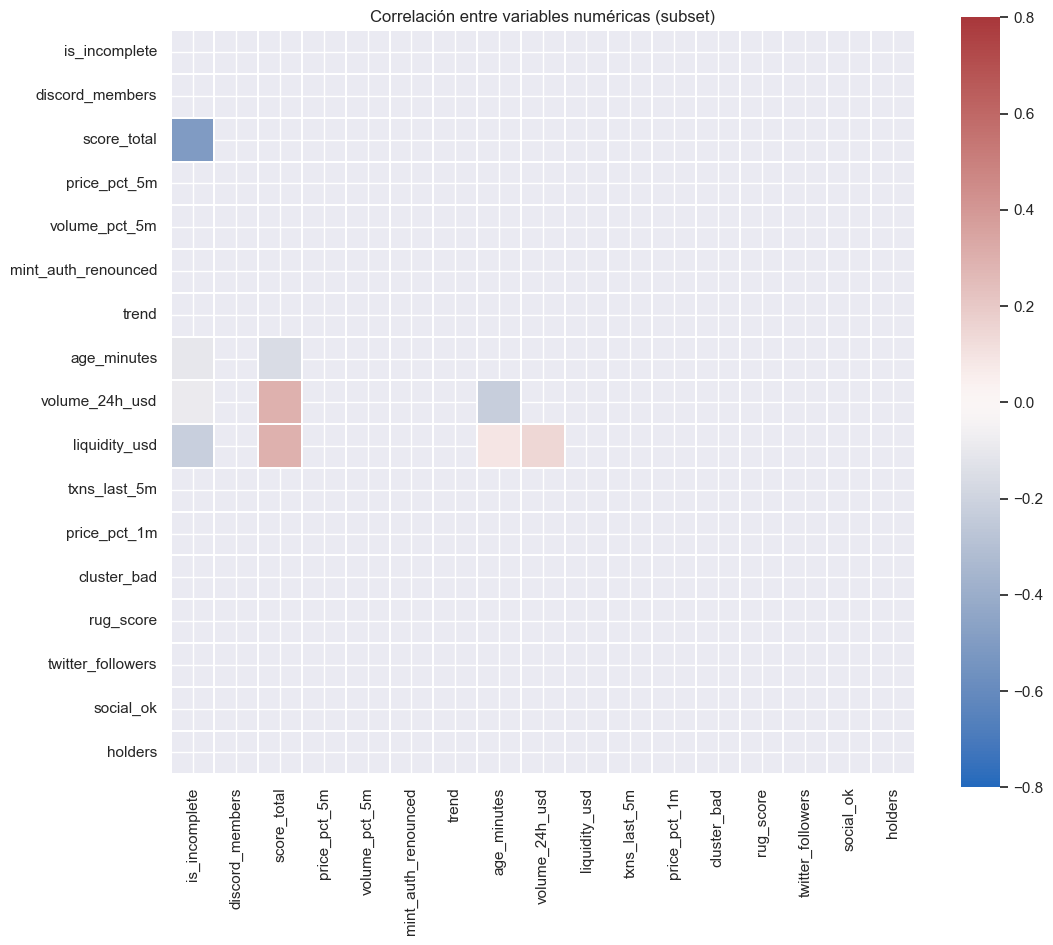

In [18]:
# %%
plt.figure(figsize=(12,10))
sample_cols = np.random.choice(num_cols, min(200, len(num_cols)), replace=False)
corr = df[sample_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmax=.8, vmin=-.8, center=0,
            cmap="vlag", square=True, linewidths=.3)
plt.title("Correlación entre variables numéricas (subset)")
plt.show()


In [19]:
# %%
def outlier_summary(series):
    vals = series.dropna()
    if vals.empty: 
        return {"iqr_outliers":0,"z>3":0,"pct_outliers":0}
    q1, q3 = np.percentile(vals, [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    z = stats.zscore(vals)
    return {
        "iqr_outliers": ((vals < low) | (vals > high)).sum(),
        "z>3": (np.abs(z) > 3).sum(),
        "pct_outliers": ((vals < low) | (vals > high)).mean()*100
    }

out_df = (pd.DataFrame({c: outlier_summary(df[c]) for c in num_cols}).T
          .sort_values("pct_outliers", ascending=False))
display(out_df.head(15))


,iqr_outliers,z>3,pct_outliers
is_incomplete,174632.0,0.0,19.445060
volume_24h_usd,170105.0,12753.0,18.940984
liquidity_usd,120954.0,13833.0,13.468080
age_minutes,22098.0,17290.0,2.460585
txns_last_5m,0.0,0.0,0.000000
rug_score,0.0,0.0,0.000000
cluster_bad,0.0,0.0,0.000000
mint_auth_renounced,0.0,0.0,0.000000
holders,0.0,0.0,0.000000
price_pct_1m,0.0,0.0,0.000000


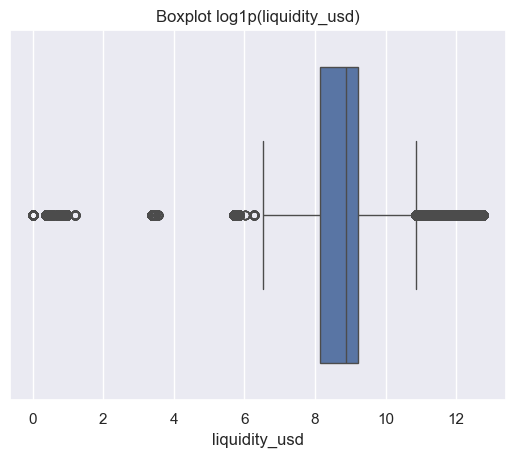

In [20]:
sns.boxplot(x=np.log1p(df["liquidity_usd"])); plt.title("Boxplot log1p(liquidity_usd)"); plt.show()


In [21]:
# %%
TOP_FEATS = corr_ser.index[:30]    # 30 con mayor |corr|
X = df[TOP_FEATS].fillna(0)
y = df["label"].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
logreg.fit(X_scaled, y)
proba_lr = logreg.predict_proba(X_scaled)[:,1]

auc_lr = roc_auc_score(y, proba_lr)
ap_lr  = average_precision_score(y, proba_lr)
print(f"AUC entrenamiento LogisticReg = {auc_lr:.4f}  —  AUC-PR = {ap_lr:.4f}")


AUC entrenamiento LogisticReg = 0.9956  —  AUC-PR = 0.7920


In [23]:
# %% ——— CV temporal con LightGBM ————————————————————————————
FEATURES = [c for c in num_cols if c != "label"]

# Orden temporal
df_sorted = df.sort_values("timestamp").reset_index(drop=True)

tscv = TimeSeriesSplit(n_splits=5)
auc_scores, ap_scores = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_sorted)):
    train_df, test_df = df_sorted.loc[train_idx], df_sorted.loc[test_idx]

    # Datasets LightGBM
    lgb_train = lgb.Dataset(train_df[FEATURES], label=train_df["label"])
    lgb_test  = lgb.Dataset(test_df[FEATURES],  label=test_df["label"])

    params = dict(
        objective="binary",
        metric="auc",
        learning_rate=0.05,
        num_leaves=64,
        min_data_in_leaf=100,
        subsample=.8,
        colsample_bytree=.8,
        seed=42,
        verbosity=-1,
    )

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=800,
        valid_sets=[lgb_test],          # ← solo objetos Dataset
        valid_names=["val"],            # ← nombre opcional
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    pred = model.predict(test_df[FEATURES], num_iteration=model.best_iteration)
    auc  = roc_auc_score(test_df["label"], pred)
    ap   = average_precision_score(test_df["label"], pred)
    auc_scores.append(auc); ap_scores.append(ap)
    print(f"Fold {fold+1}: AUC={auc:.4f}  AUC-PR={ap:.4f}")

print(f"\nMedia AUC={np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Media AUC-PR={np.mean(ap_scores):.4f} ± {np.std(ap_scores):.4f}")


Fold 1: AUC=0.9994  AUC-PR=0.7926


d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 2: AUC=nan  AUC-PR=0.0000


d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 3: AUC=nan  AUC-PR=0.0000


d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 4: AUC=nan  AUC-PR=0.0000
Fold 5: AUC=nan  AUC-PR=0.0000

Media AUC=nan ± nan
Media AUC-PR=0.1585 ± 0.3170


d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


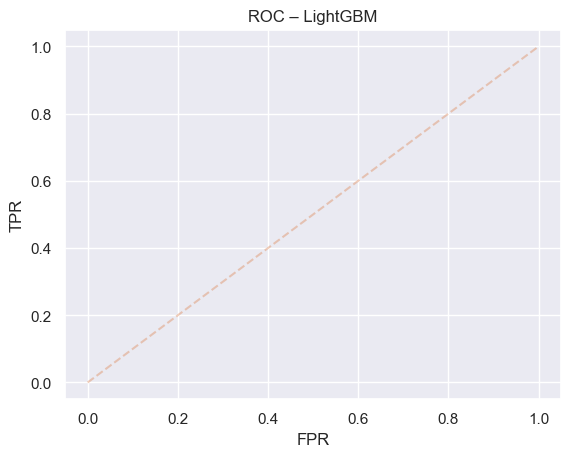

d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\Dev\Python\memebot3\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


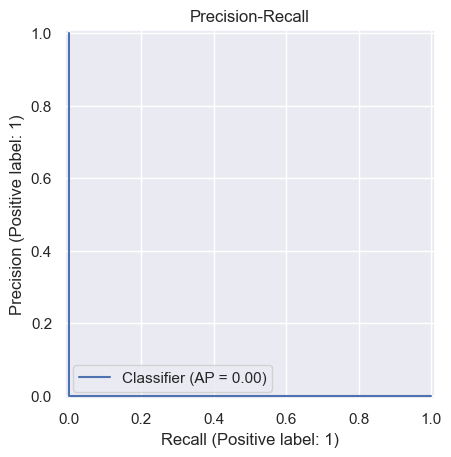

Umbral óptimo (Youden): inf


In [24]:
# %%
test_df = df_sorted.loc[test_idx]     # último split
pred    = model.predict(test_df[FEATURES], num_iteration=model.best_iteration)

# ROC
fpr, tpr, thr = roc_curve(test_df["label"], pred)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--",alpha=.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – LightGBM"); plt.show()

# PR
disp = PrecisionRecallDisplay.from_predictions(test_df["label"], pred)
disp.ax_.set_title("Precision-Recall"); plt.show()

# Umbral óptimo (Youden)
g = tpr - fpr
best_idx = np.argmax(g)
best_thr = thr[best_idx]
print(f"Umbral óptimo (Youden): {best_thr:.3f}")


In [26]:
# %% ——— Importancia de variables + SHAP opcional ———————————
imp_df = (
    pd.DataFrame({
        "feature": FEATURES,
        "gain": model.feature_importance()
    })
    .sort_values("gain", ascending=False)
)

display(imp_df.head(25))

# —— guardar top-features ——
TOP40 = imp_df.head(40)["feature"].tolist()
path_top = REPO / "memebot3" / "ml" / "top_features.txt"
path_top.parent.mkdir(parents=True, exist_ok=True)
path_top.write_text("\n".join(TOP40))
print("✔ top_features.txt guardado en", path_top)

# —— SHAP summary (solo si SHAP_OK) ——
if "SHAP_OK" in globals() and SHAP_OK:
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(test_df[FEATURES].head(5_000))  # muestra para velocidad
    shap.summary_plot(shap_vals, test_df[FEATURES].head(5_000), show=False)
    plt.title("SHAP summary (LightGBM)")
    plt.show()
else:
    print("· SHAP no disponible; se omite la gráfica de explicabilidad.")


,feature,gain
1,liquidity_usd,41
0,age_minutes,20
14,score_total,2
3,txns_last_5m,0
2,volume_24h_usd,0
5,rug_score,0
6,cluster_bad,0
7,mint_auth_renounced,0
4,holders,0
8,price_pct_1m,0


✔ top_features.txt guardado en D:\Dev\Python\memebot3\ml\top_features.txt
· SHAP no disponible; se omite la gráfica de explicabilidad.


In [27]:
# %%
MODEL_DIR = REPO / "memebot3" / "ml"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(model,       MODEL_DIR / "model.pkl")
joblib.dump(scaler,      MODEL_DIR / "scaler.pkl")
json.dump(
    {"features": FEATURES, "auc": float(np.mean(auc_scores)), "auc_pr": float(np.mean(ap_scores)),
     "threshold": float(best_thr)},
    open(MODEL_DIR / "model.meta.json", "w"), indent=2
)
print("Modelo, scaler y metadatos guardados en", MODEL_DIR)


Modelo, scaler y metadatos guardados en D:\Dev\Python\memebot3\ml


In [28]:
# %%
batch = df_sorted[FEATURES].iloc[:1_000].fillna(0)
start = time.time()
_ = model.predict(batch, num_iteration=model.best_iteration)
print(f"Tiempo por 1 000 predicciones: {time.time()-start:.4f}s → {1e3*(time.time()-start)/len(batch):.2f} ms/row")


Tiempo por 1 000 predicciones: 0.0000s → 0.00 ms/row
